In [1]:
import os
import pickle
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IForest import read_data_samples
from sklearn.decomposition import KernelPCA

In [2]:
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [3]:
def read_data_samples():

    with open('data/lightcurves.pickle', 'rb') as file:
        lightcurves = pickle.load(file)

    filtered_lcs = lightcurves['pca']
    flux = filtered_lcs['flux_pca']
#     flux = lightcurves['flux']

    return flux

In [4]:
data = read_data_samples()

In [5]:
data.shape

(3873, 300)

In [6]:
# data = pd.DataFrame(data)
# data.head()

In [7]:
PCA_Estimator = KernelPCA(n_components=2, kernel='rbf',
                                gamma=0.001, alpha=0.001,
                                fit_inverse_transform=True,
                                n_jobs=-1)     

In [8]:
transformed_data = PCA_Estimator.fit_transform(data, y=None)

In [9]:
transformed_data.shape

(3873, 2)

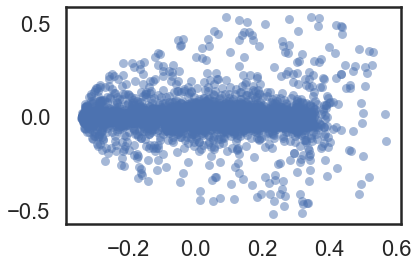

In [10]:
plt.scatter(transformed_data.T[0], transformed_data.T[1], color='b', **plot_kwds)

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=16, min_samples=16,gen_min_span_tree=True)

In [12]:
clusterer.fit(transformed_data)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=16, min_samples=16)

In [13]:
clusterer.labels_

array([ 3,  3,  3, ..., -1, -1, -1])

In [14]:
clusterer.labels_.max()

7

In [15]:
clusterer.probabilities_

array([0.38786313, 0.70315783, 0.61690023, ..., 0.        , 0.        ,
       0.        ])

In [16]:
clusterer.condensed_tree_

<AxesSubplot:ylabel='$\\lambda$ value'>

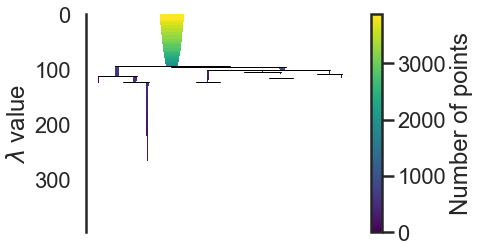

In [17]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

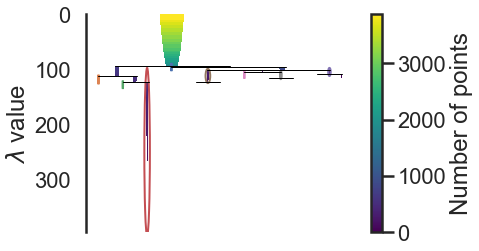

In [18]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

<AxesSubplot:>

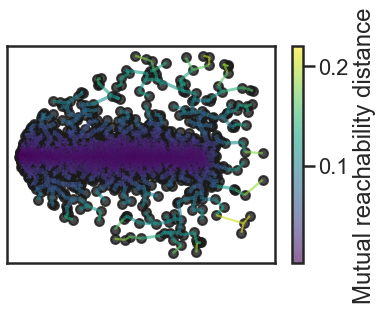

In [19]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

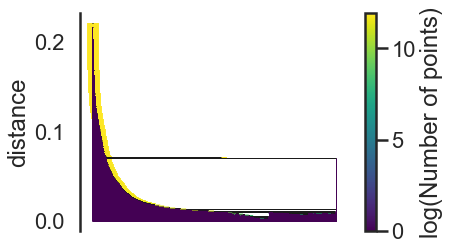

In [20]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

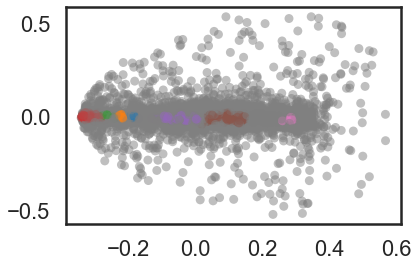

In [21]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(transformed_data.T[0], transformed_data.T[1], c=cluster_colors, **plot_kwds)

In [22]:
g = clusterer.condensed_tree_.to_networkx()
g.number_of_nodes()

3894

In [23]:
clusterer.condensed_tree_.to_pandas().head()

,parent,child,lambda_val,child_size
0,3873,947,4.549244,1
1,3873,1104,4.645784,1
2,3873,1087,4.912579,1
3,3873,560,4.952674,1
4,3873,1749,4.959087,1


In [24]:
tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = tree[tree.child_size > 1]
cluster_tree.head()

,parent,child,lambda_val,child_size
2144,3873,3874,94.787272,671
2145,3873,3875,94.787272,1058
2171,3875,3876,95.129816,18
2172,3875,3877,95.129816,1028
2359,3874,3878,111.456064,37


In [25]:
cluster_tree.shape

(20, 4)

In [26]:
clusterer.outlier_scores_

array([0.61213687, 0.29684217, 0.38309977, ..., 0.79324471, 0.00377978,
       0.0999261 ])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

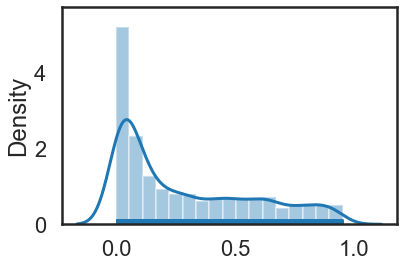

In [27]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [28]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
outliers.shape


(388,)

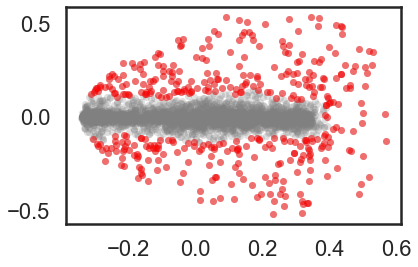

In [29]:
plt.scatter(*transformed_data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*transformed_data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)